In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [5]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.15.0
2.2.4


# OmniFold Gaussian Toy Example

We will unfold the same data but with two cases:

(a) there are no generator MC weights from using simulation.

(b) there are generator MC weights from using simulation.

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

In [7]:
N = 10**6
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (1, 1.5)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

theta0_G = np.random.normal(theta0_param[0], theta0_param[1],
                            N)  # Generator-level synthetic sample

# Toy MC weights from "MC sampling"
weightsMC_0 = np.array([(np.random.normal(abs(x), epsilon)) for x in theta0_G
                      ])  # Detector smearing for synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G
                     ])  # Detector smearing for synthetic sample
theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

theta_unknown_G = np.random.normal(theta_unknown_param[0],
                                   theta_unknown_param[1], N)
# Toy MC weights from "MC sampling"
weightsMC_unknown = np.array([
    (np.random.normal(abs(x), epsilon)) for x in theta_unknown_G
])  
# Detector smearing for synthetic sample
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon))
                            for x in theta_unknown_G]) 
theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

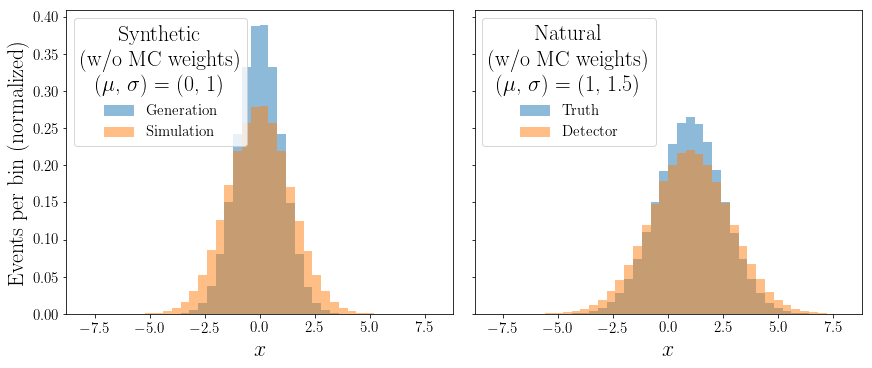

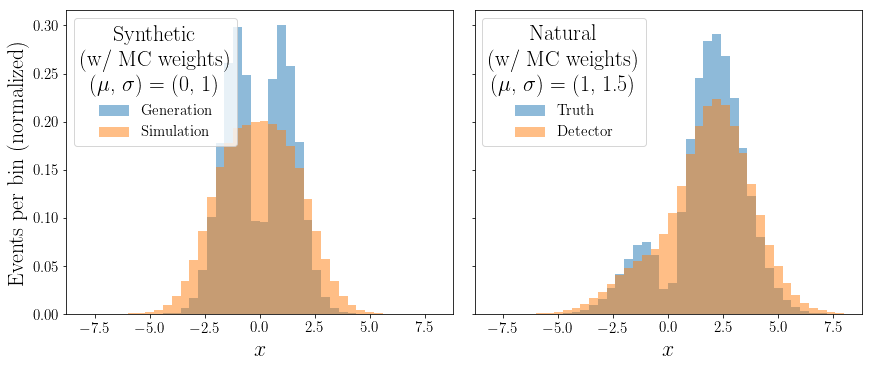

In [8]:
bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G, bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S, bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n(w/o MC weights)\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G, bins=bins, **plot_style_2, label='Truth')
ax[1].hist(theta_unknown_S, bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    title='Natural\n(w/o MC weights)\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G,
           weights=weightsMC_0,
           bins=bins,
           **plot_style_2,
           label='Generation')
ax[0].hist(theta0_S,
           weights=weightsMC_0,
           bins=bins,
           **plot_style_2,
           label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n(w/ MC weights)\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G,
           weights=weightsMC_unknown,
           bins=bins,
           **plot_style_2,
           label='Truth')
ax[1].hist(theta_unknown_S,
           weights=weightsMC_unknown,
           bins=bins,
           **plot_style_2,
           label='Detector')
legend = ax[1].legend(
    title='Natural\n(w/ MC weights)\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [9]:
iterations = 5

In [10]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [11]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(weights)

### Unfold without initial MC weights

In [12]:
# initial iterative weights are ones

weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [13]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    weights_push = reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1500000 samples, validate on 500000 samples
Epoch 1/200





1500000/1500000 [==============================] - 14s 9us/step - loss: 0.6442 - acc: 0.6197 - val_loss: 0.6359 - val_acc: 0.6318
Epoch 2/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6357 - val_acc: 0.6320
Epoch 3/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6355 - val_acc: 0.6320
Epoch 4/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6355 - val_acc: 0.6319
Epoch 5/200
1500000/1500000 [==============================] - 11s 8us/step - loss: 0.6361 - acc: 0.6303 - val_loss: 0.6358 - val_acc: 0.6319
Epoch 6/200
1500000/1500000 [==============================] - 11s 8us/step - loss: 0.6362 - acc: 0.6302 - val

1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6804 - acc: 0.5976 - val_loss: 0.6788 - val_acc: 0.5931
Epoch 12/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6803 - acc: 0.5968 - val_loss: 0.6789 - val_acc: 0.6025
Epoch 13/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6804 - acc: 0.5973 - val_loss: 0.6789 - val_acc: 0.6008
Epoch 14/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6803 - acc: 0.5974 - val_loss: 0.6789 - val_acc: 0.5966
Epoch 15/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6803 - acc: 0.5967 - val_loss: 0.6790 - val_acc: 0.5910
Epoch 16/200
1500000/1500000 [==============================] - 13s 8us/step - loss: 0.6803 - acc: 0.5968 - val_loss: 0.6789 - val_acc: 0.5969
Epoch 17/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6803 - acc: 0.5958 - val_loss: 0.6789 - val_acc: 0.6005
Epoch 18/200

ITERATION 1:


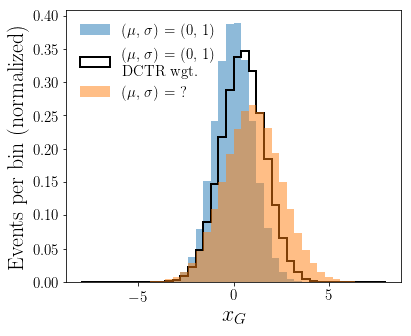

ITERATION 2:


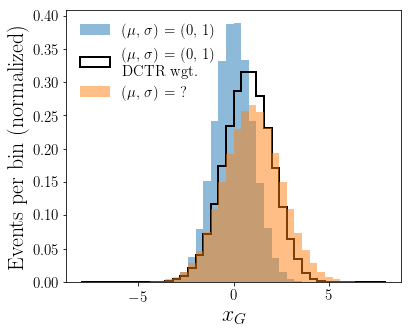

ITERATION 3:


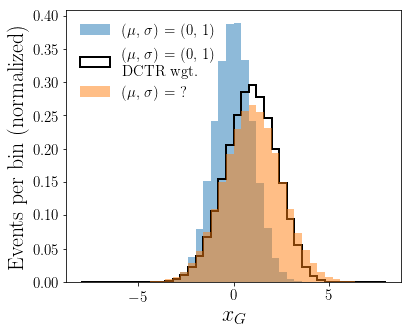

ITERATION 4:


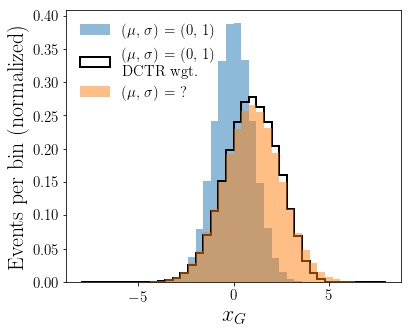

ITERATION 5:


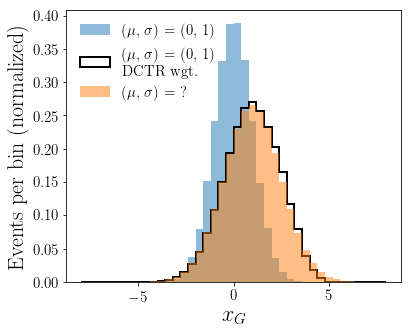

In [14]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_G,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    hist1 = plt.hist(
        theta0_G,
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_G,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$x_G$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()

### Unfold with initial MC weights

In [15]:
# increase number of iterations
iterations = 20

In [16]:
# initial iterative weights are MC weights

weights_pull = weightsMC_0
weights_push = weightsMC_0

In [17]:
# clear total weights

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)

In [18]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    weights_1 = np.concatenate((weights_push, weightsMC_unknown))
    # actual weights for Sim., initial MC weights for Data

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1,
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    weights_pull = weights_push * reweight(theta0_S)
    weights[i, :1, :] = weights_pull

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    weights_2 = np.concatenate((weightsMC_0, weights_pull))
    # initial MC weights for Gen., actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)
    
    # note we need to take into account MC weights when reweighting the synthetic gen.
    weights_push = weightsMC_0 * reweight(theta0_G)
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 14s 10us/step - loss: 0.6178 - acc: 0.6202 - val_loss: 0.6191 - val_acc: 0.6149
Epoch 2/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6159 - acc: 0.6178 - val_loss: 0.6191 - val_acc: 0.6151
Epoch 3/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.6159 - acc: 0.6183 - val_loss: 0.6187 - val_acc: 0.6167
Epoch 4/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6158 - acc: 0.6184 - val_loss: 0.6188 - val_acc: 0.6168
Epoch 5/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.6158 - acc: 0.6183 - val_loss: 0.6192 - val_acc: 0.6185
Epoch 6/200
1500000/1500000 [==============================] - 11s 8us/step - loss: 0.6159 - acc: 0.6183 - val_loss: 0.6188 - val_acc: 0.6163
Epoch 7/200
1500000/1500000 [==============================] - 12s 8us/

Epoch 7/200
1500000/1500000 [==============================] - 14s 10us/step - loss: 0.5986 - acc: 0.5003 - val_loss: 0.5996 - val_acc: 0.4993
Epoch 8/200
1500000/1500000 [==============================] - 15s 10us/step - loss: 0.5986 - acc: 0.5003 - val_loss: 0.5994 - val_acc: 0.4991
Epoch 9/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5985 - acc: 0.5004 - val_loss: 0.5994 - val_acc: 0.4993
Epoch 10/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.5986 - acc: 0.5003 - val_loss: 0.5995 - val_acc: 0.4993
Epoch 11/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5986 - acc: 0.5003 - val_loss: 0.5995 - val_acc: 0.4991
Epoch 12/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5986 - acc: 0.5003 - val_loss: 0.5998 - val_acc: 0.4989
Epoch 13/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5986 - acc: 0.5003 - val_loss: 0.5994 - val_acc: 0.4991


1500000/1500000 [==============================] - 12s 8us/step - loss: 1.0184 - acc: 0.4534 - val_loss: 0.9992 - val_acc: 0.4216
Epoch 13/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 1.0183 - acc: 0.4404 - val_loss: 0.9973 - val_acc: 0.4605
Epoch 14/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 1.0188 - acc: 0.4323 - val_loss: 0.9952 - val_acc: 0.4662
Epoch 15/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 1.0186 - acc: 0.4602 - val_loss: 0.9973 - val_acc: 0.4503
Epoch 16/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 1.0186 - acc: 0.4456 - val_loss: 0.9952 - val_acc: 0.4431
Epoch 17/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 1.0184 - acc: 0.4504 - val_loss: 0.9950 - val_acc: 0.4759
Epoch 18/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 1.0182 - acc: 0.4522 - val_loss: 0.9974 - val_acc: 0.4251
Epoch 19/200

1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5536 - acc: 0.4998 - val_loss: 0.5563 - val_acc: 0.5007
Epoch 5/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5536 - acc: 0.4997 - val_loss: 0.5562 - val_acc: 0.5007
Epoch 6/200
1500000/1500000 [==============================] - 13s 8us/step - loss: 0.5536 - acc: 0.4998 - val_loss: 0.5562 - val_acc: 0.5007
Epoch 7/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5536 - acc: 0.4998 - val_loss: 0.5562 - val_acc: 0.5008
Epoch 8/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5536 - acc: 0.4998 - val_loss: 0.5563 - val_acc: 0.5006
Epoch 9/200
1500000/1500000 [==============================] - 13s 8us/step - loss: 0.5536 - acc: 0.4998 - val_loss: 0.5563 - val_acc: 0.5008
Epoch 10/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.5536 - acc: 0.4997 - val_loss: 0.5562 - val_acc: 0.5007
Epoch 11/200
1500

1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5524 - acc: 0.5001 - val_loss: 0.5522 - val_acc: 0.4996
Epoch 10/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5524 - acc: 0.5001 - val_loss: 0.5519 - val_acc: 0.4997
Epoch 11/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5524 - acc: 0.5000 - val_loss: 0.5521 - val_acc: 0.4996
Epoch 12/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5524 - acc: 0.5002 - val_loss: 0.5520 - val_acc: 0.4997
Epoch 13/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5524 - acc: 0.5002 - val_loss: 0.5522 - val_acc: 0.4996
Epoch 14/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5524 - acc: 0.5001 - val_loss: 0.5521 - val_acc: 0.4996
Epoch 15/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5523 - acc: 0.5000 - val_loss: 0.5520 - val_acc: 0.4997
Restoring mo

1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5472 - acc: 0.4999 - val_loss: 0.5483 - val_acc: 0.5002
Epoch 12/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5472 - acc: 0.5000 - val_loss: 0.5483 - val_acc: 0.5001
Epoch 13/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.5473 - acc: 0.5001 - val_loss: 0.5484 - val_acc: 0.5001
Restoring model weights from the end of the best epoch
Epoch 00013: early stopping

ITERATION: 15

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 16s 11us/step - loss: 1.0545 - acc: 0.5573 - val_loss: 0.9833 - val_acc: 0.5104
Epoch 2/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.9898 - acc: 0.5663 - val_loss: 0.9748 - val_acc: 0.6055
Epoch 3/200
1500000/1500000 [==============================] - 13s 9us/step - loss: 0.9872 - acc: 0.5398 - val_loss: 0.9734 - val_acc: 0.62

1500000/1500000 [==============================] - 14s 10us/step - loss: 0.5513 - acc: 0.5000 - val_loss: 0.5524 - val_acc: 0.5002
Epoch 12/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.5514 - acc: 0.4999 - val_loss: 0.5524 - val_acc: 0.5000
Epoch 13/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5513 - acc: 0.4999 - val_loss: 0.5524 - val_acc: 0.5001
Epoch 14/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5513 - acc: 0.5000 - val_loss: 0.5529 - val_acc: 0.5001
Epoch 15/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5513 - acc: 0.5000 - val_loss: 0.5524 - val_acc: 0.5001
Epoch 16/200
1500000/1500000 [==============================] - 11s 8us/step - loss: 0.5514 - acc: 0.5000 - val_loss: 0.5523 - val_acc: 0.5000
Epoch 17/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.5514 - acc: 0.4999 - val_loss: 0.5524 - val_acc: 0.5002
Restoring m

1500000/1500000 [==============================] - 8s 6us/step - loss: 0.9676 - acc: 0.4715 - val_loss: 0.9592 - val_acc: 0.5135
Epoch 17/200
1500000/1500000 [==============================] - 8s 6us/step - loss: 0.9672 - acc: 0.4914 - val_loss: 0.9602 - val_acc: 0.5031
Epoch 18/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.9670 - acc: 0.4919 - val_loss: 0.9590 - val_acc: 0.5000
Epoch 19/200
1500000/1500000 [==============================] - 8s 6us/step - loss: 0.9682 - acc: 0.4875 - val_loss: 0.9589 - val_acc: 0.5116
Epoch 20/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.9669 - acc: 0.4984 - val_loss: 0.9598 - val_acc: 0.5000
Epoch 21/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.9672 - acc: 0.4922 - val_loss: 0.9595 - val_acc: 0.5000
Epoch 22/200
1500000/1500000 [==============================] - 9s 6us/step - loss: 0.9670 - acc: 0.4929 - val_loss: 0.9589 - val_acc: 0.5000
Epoch 23/200
150000

Epoch 35/200
1500000/1500000 [==============================] - 8s 6us/step - loss: 0.5612 - acc: 0.5000 - val_loss: 0.5605 - val_acc: 0.5001
Epoch 36/200
1500000/1500000 [==============================] - 8s 6us/step - loss: 0.5612 - acc: 0.5000 - val_loss: 0.5606 - val_acc: 0.5000
Restoring model weights from the end of the best epoch
Epoch 00036: early stopping


ITERATION 1:


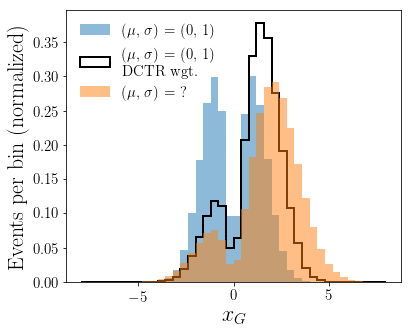

ITERATION 2:


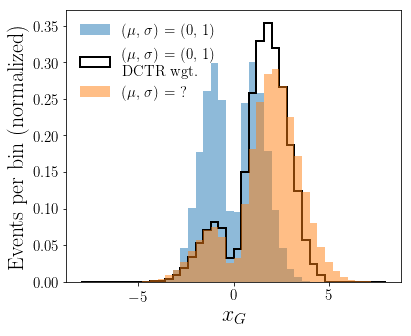

ITERATION 3:


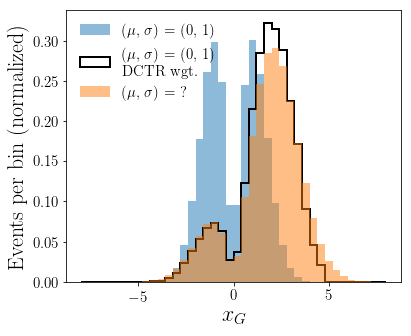

ITERATION 4:


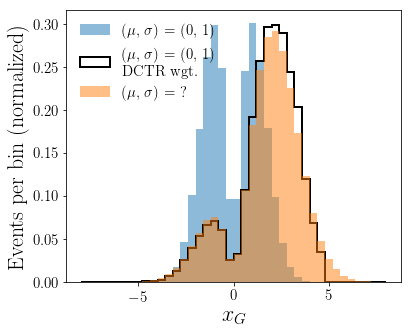

ITERATION 5:


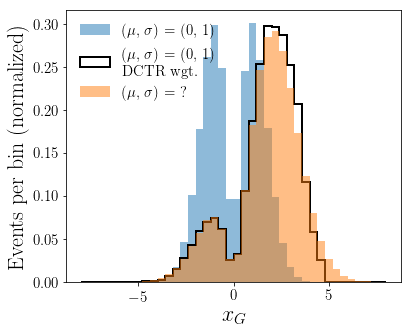

ITERATION 6:


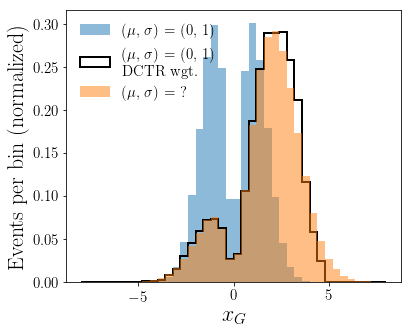

ITERATION 7:


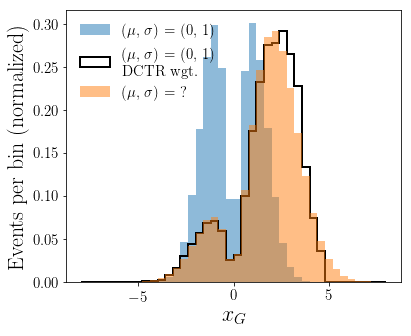

ITERATION 8:


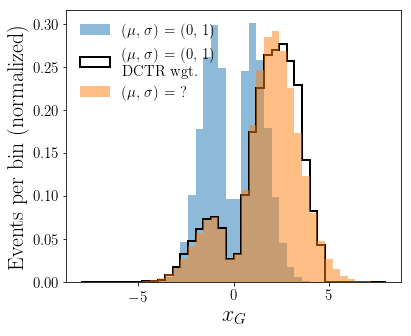

ITERATION 9:


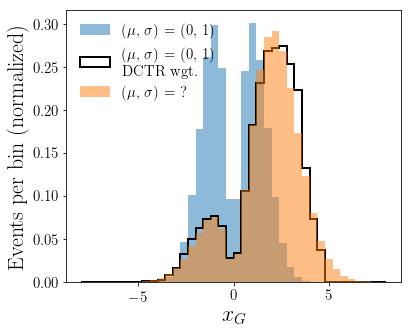

ITERATION 10:


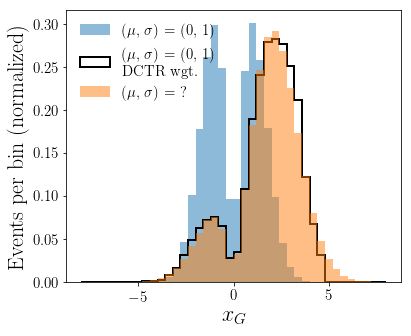

ITERATION 11:


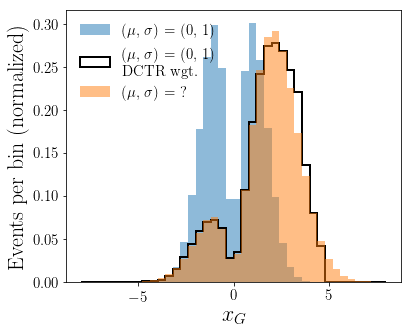

ITERATION 12:


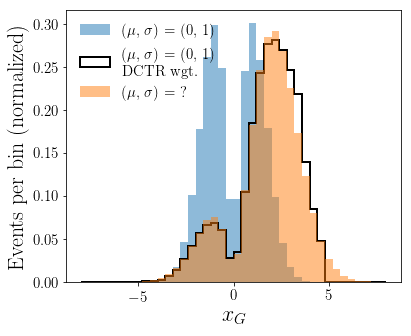

ITERATION 13:


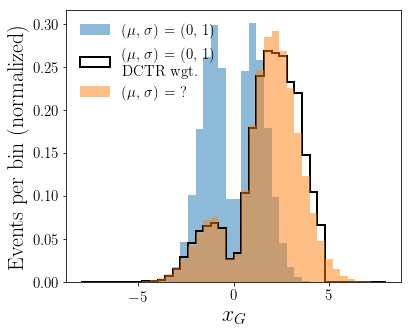

ITERATION 14:


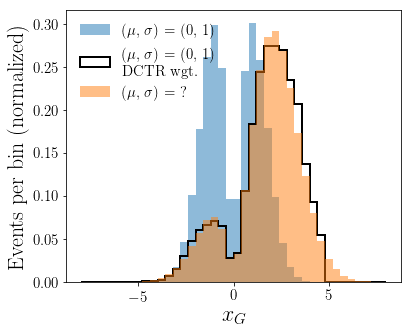

ITERATION 15:


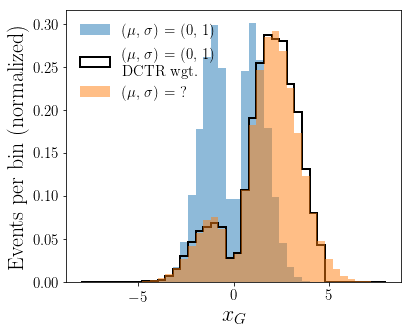

ITERATION 16:


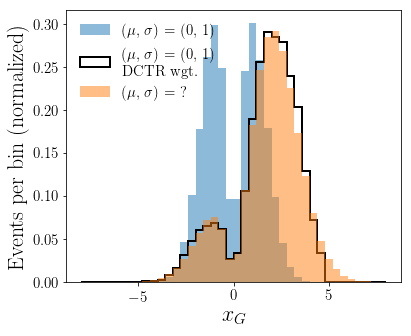

ITERATION 17:


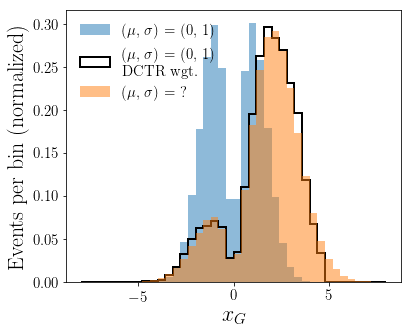

ITERATION 18:


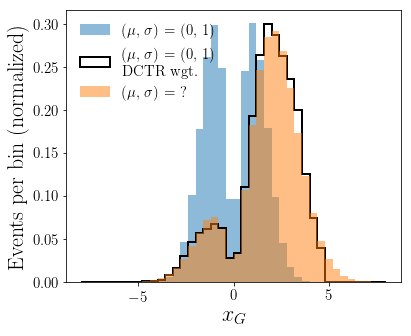

ITERATION 19:


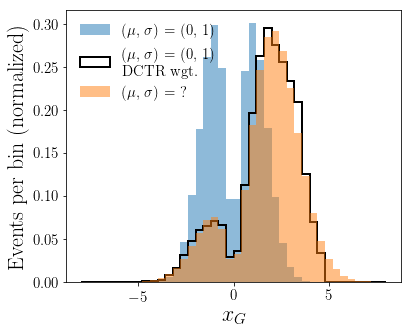

ITERATION 20:


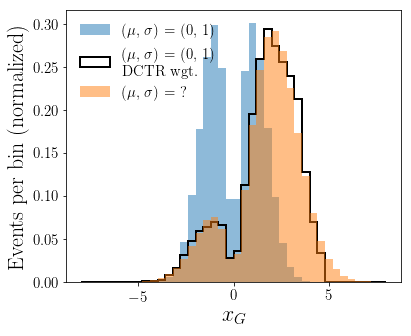

In [19]:
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(6, 5))
    hist0 = plt.hist(theta0_G,
                     weights=weightsMC_0,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    hist1 = plt.hist(
        theta0_G,
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :],
        **plot_style_1)
    hist2 = plt.hist(theta_unknown_G,
                     weights=weightsMC_unknown,
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2)
    plt.legend(frameon=False)
    plt.xlabel(r"$x_G$")
    plt.ylabel("Events per bin (normalized)")
    plt.show()